# Feature Engeneering for ride duration of taxi trips in New York City

In this notebook we explore feature extraction to build a model that predicts the total ride duration of taxi trips in New York City. We are using data from a Kaggle competition (https://www.kaggle.com/c/nyc-taxi-trip-duration/).

You may need to `pip install xgboost`

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import warnings

In [2]:
plt.rcParams['figure.figsize'] = [13, 5]

## Initail data exploration

In [3]:
path = "/data2/yinterian/nyc-taxi-trip-duration/"

In [4]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [5]:
train.shape

(1458644, 11)

In [6]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Data Description
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

### Cleaning and transforming target variable

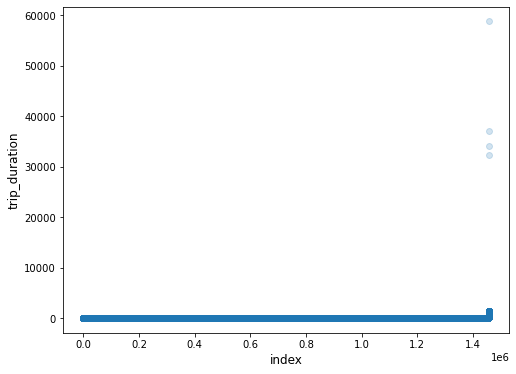

In [7]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip_duration', fontsize=12)
plt.show()

In [8]:
# initial cleaning
train["trip_duration"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1])

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

In [9]:
# The 99 quantile is 57. 3 minutes 
# clipping trips logger than one hour  
train.loc[train["trip_duration"] > 60*60, "trip_duration"] = 60*60

# clipping trips less that one minute  
train.loc[train["trip_duration"] < 60, "trip_duration"] = 60

print(train.shape)

(1458644, 11)


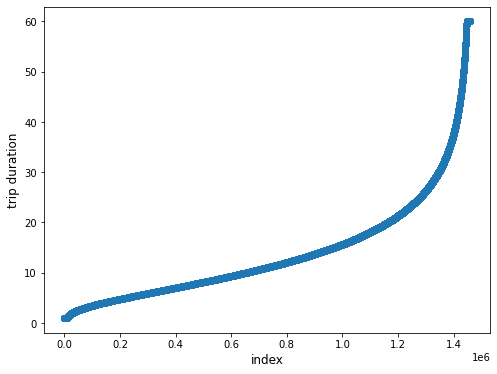

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

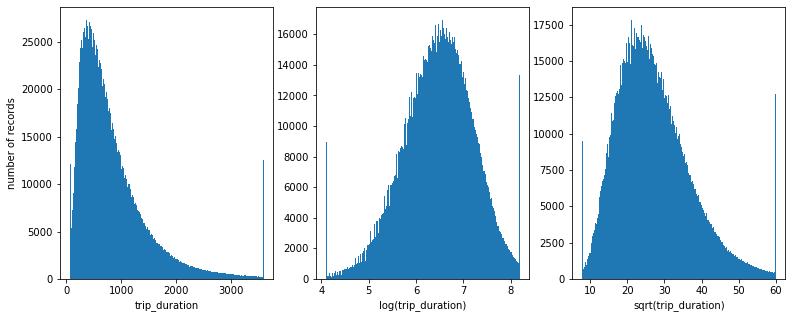

In [11]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

## Distance & Speed

In [12]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [13]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,sqrt_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,21.330729
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,25.748786
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,46.086874
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,20.712315
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,20.856654


In [14]:
# this formulas accepts nump arrays
from math import radians, cos, sin, asin, sqrt

def L2_distance(lon1, lat1, lon2, lat2):
    """ Approximate distance
    """
    dlon = (lon2 - lon1)**2 
    dlat = (lat2 - lat1)**2
    return 1000*np.sqrt(dlon + dlat)

In [15]:
def compute_distance(df):
    lon1 = df['pickup_longitude'].values
    lat1 = df['pickup_latitude'].values
    lon2 = df['dropoff_longitude'].values
    lat2 = df['dropoff_latitude'].values
    return L2_distance(lon1, lat1, lon2, lat2)

In [16]:
train['distance'] = compute_distance(train)
test['distance'] = compute_distance(test)

In [17]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,sqrt_trip_duration,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,8.354563e+02,6.465324e+00,2.712671e+01,3.548232e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,6.356312e+02,7.494093e-01,9.979872e+00,4.596807e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.000000e+01,4.094345e+00,7.745967e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,5.983936e+00,1.992486e+01,1.258443e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,6.495266e+00,2.572936e+01,2.121671e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,6.980076e+00,3.278719e+01,3.840884e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.600000e+03,8.188689e+00,6.000000e+01,1.119260e+04


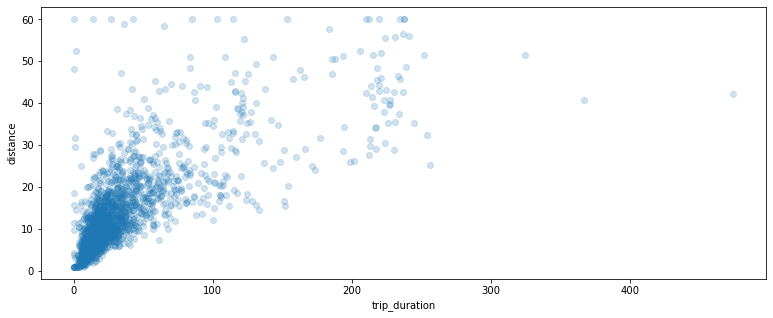

array([[1.        , 0.73845563],
       [0.73845563, 1.        ]])

In [18]:
y = train['trip_duration'][:2000]/60
x = train['distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration')
plt.ylabel('distance')
plt.show()
np.corrcoef(x,y)

In [19]:
# ?miles an hour
train["speed"] = train["distance"]/ (train["trip_duration"] / 360.0)

Note that 'speed' is not a feature since it needs trip duration which is the target variable.
We are using it just as part of our exploration

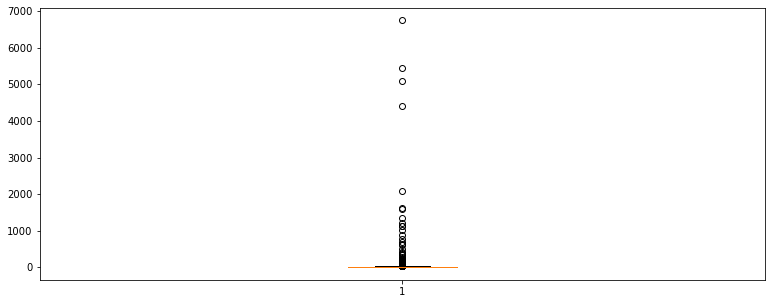

In [20]:
plt.boxplot(train['speed'])
plt.show()

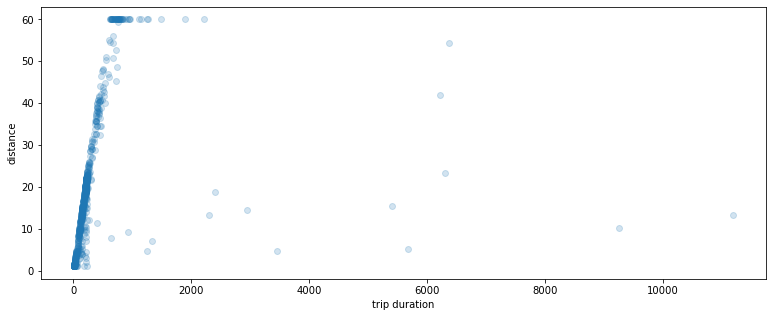

In [21]:
tmp = train[train['speed'] > 60]
y = tmp['trip_duration']/60
x = tmp['distance']
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip duration')
plt.ylabel('distance')
plt.show()

In [22]:
# some more clipping here
train['speed'].quantile([.0, 0.25, .5, 0.75, 0.999, 1])

0.000       0.000000
0.250       9.276128
0.500      12.943377
0.750      18.009364
0.999      55.959545
1.000    6749.747037
Name: speed, dtype: float64

In [23]:
ind = train['speed'] > 60
v = train.loc[ind, 'distance']/60

In [24]:
train.loc[ind, "trip_duration"] = v

In [25]:
train.shape

(1458644, 15)

## Time features

We will define some time features. By plotting every feature agains the "trip_duration" or "speed" we will be able to see if there is any useful correlations. 

In [26]:
def get_time_features(df):
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.isocalendar().week
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    return df

In [27]:
train = get_time_features(train)
test = get_time_features(test)

<AxesSubplot:title={'center':'speed'}, xlabel='[pickup_hour]'>

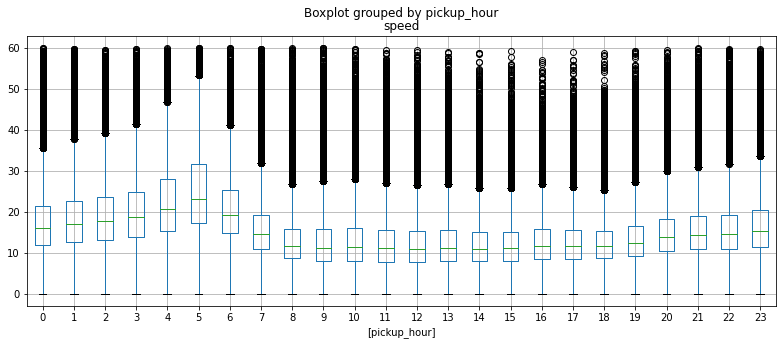

In [28]:
tmp = train[train['speed'] < 60]
metric = 'pickup_hour'
y = 'speed'
tmp.boxplot(column=y, by=[metric])

Looks like speed is lower in the middle of the day which makes pickup hour a likely useful feature.

Plot other features. Do they seem useful?

## Clustering based on lat and long

In [29]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [30]:
places.shape

(2917288, 2)

In [31]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(places)

In [32]:
# here the new features is the id of the cluster
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [33]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,sqrt_trip_duration,distance,speed,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_week_hour,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,6.120297,21.330729,17.679539,13.988207,0,11,17,17,87,22
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.496775,25.748786,20.455904,11.107278,6,23,0,144,24,75
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,7.661056,46.086874,59.933799,10.158271,1,3,11,35,40,93
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6.061457,20.712315,13.438206,11.276816,2,14,19,67,48,93
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6.075346,20.856654,10.689569,8.846540,5,12,13,133,98,91


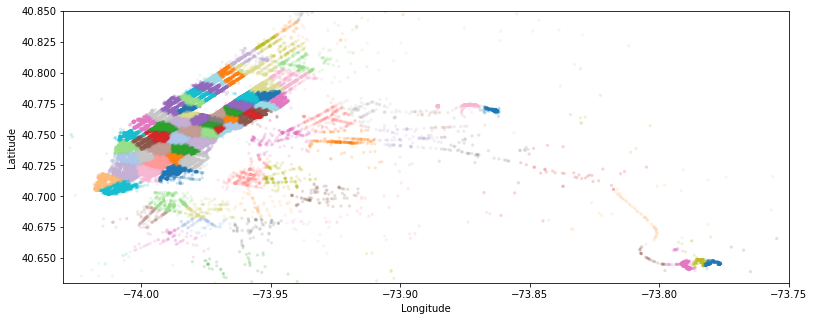

In [34]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

## Split train and validation

In [35]:
# split train and validation
np.random.seed(3)
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk].copy()
val_set = train[~msk].copy()
print(train_set.shape, val_set.shape)

(1165908, 21) (292736, 21)


## Target Encoding (naive version)

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data. This is a naive version of target encoding. We will discuss a better version next class.

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [36]:
col = 'pickup_weekday'
gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
gby

,speed_gby_pickup_weekday,log_trip_duration_gby_pickup_weekday
pickup_weekday,,
0,15.391604,6.426236
1,13.965800,6.489996
2,13.740403,6.511811
3,13.672504,6.526877
4,13.963899,6.497713
5,15.167796,6.415824
6,16.935512,6.374934


In [37]:
for col in ['pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=col, right_index=True)

In [38]:
train_set.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_gby_pickup_weekofyear,log_trip_duration_gby_pickup_weekofyear,speed_gby_pickup_hour,log_trip_duration_gby_pickup_hour,speed_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,speed_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,speed_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,14.699380,6.455396,12.686733,6.536486,13.234056,6.470105,12.761118,6.484662,12.488274,6.249488
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,14.239944,6.529787,17.865169,6.420345,15.697268,6.464233,13.355075,6.382841,12.789798,6.317740
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,14.556325,6.425675,12.624685,6.522413,10.966625,6.639628,12.216922,6.535633,16.603734,6.712084
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,14.298784,6.466657,13.739711,6.439932,13.185585,6.460520,14.303004,6.537313,16.603734,6.712084
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,...,14.560128,6.499111,16.160027,6.464392,14.637641,6.508676,13.619622,6.503197,13.942632,6.369908


In [39]:
# here we use two variable at a time
for cols in [['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    speed = train_set.groupby(cols).mean()[['speed']].reset_index()
    count = train.groupby(cols).count()[['id']].reset_index()
    stats = pd.merge(speed, count, on=cols)
    stats = stats[stats['id'] > 100] # discarding stats with < 100 observations
    stats.columns = cols + ['speed_%s' % '_'.join(cols), 'cnt_%s' %  '_'.join(cols)]
    train_set = pd.merge(train_set, stats, how='left', on=cols)
    val_set = pd.merge(val_set, stats, how='left', on=cols)
    test = pd.merge(test, stats, how='left', on=cols)

In [40]:
# here is an example
cols = ['pickup_hour', 'pickup_cluster']
speed = train_set.groupby(cols).mean()[['speed']].reset_index()
speed.head()

,pickup_hour,pickup_cluster,speed
0,0,0,17.996324
1,0,1,42.437630
2,0,2,15.605047
3,0,3,20.876322
4,0,4,33.846862


In [41]:
# here is how you compute the median instead
cols = ['pickup_hour', 'pickup_cluster']
speed_median = train_set.groupby(cols).median()[['speed']].reset_index()
speed_median.head()

,pickup_hour,pickup_cluster,speed
0,0,0,16.811099
1,0,1,43.927635
2,0,2,13.999767
3,0,3,19.779938
4,0,4,33.379164


In [42]:
# where are the NAs
df_na = train_set.isnull().any()
[fea for fea in df_na.index if df_na[fea]]

['speed_pickup_hour_pickup_cluster',
 'cnt_pickup_hour_pickup_cluster',
 'speed_pickup_hour_dropoff_cluster',
 'cnt_pickup_hour_dropoff_cluster',
 'speed_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [43]:
# fix NAs
for col in  ['speed_pickup_cluster_dropoff_cluster',
             'speed_pickup_hour_pickup_cluster',
             'speed_pickup_hour_dropoff_cluster']:
    m = train_set[col].mean()
    print(col, m)
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

speed_pickup_cluster_dropoff_cluster 13.873876931061425
speed_pickup_hour_pickup_cluster 14.570382286447007
speed_pickup_hour_dropoff_cluster 14.449949022683066


In [44]:
for col in ['cnt_pickup_cluster_dropoff_cluster', 'cnt_pickup_hour_pickup_cluster', 
            'cnt_pickup_hour_dropoff_cluster']:
    m = 0
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

## Initial model

In [45]:
train_set.columns.shape

(39,)

In [46]:
ind = [4, 5, 6, 7, 8, 13] + list(range(15, 39))
features = train_set.columns[ind]
features

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_weekday',
       'pickup_weekofyear', 'pickup_hour', 'pickup_week_hour',
       'pickup_cluster', 'dropoff_cluster', 'speed_gby_pickup_weekday',
       'log_trip_duration_gby_pickup_weekday', 'speed_gby_pickup_weekofyear',
       'log_trip_duration_gby_pickup_weekofyear', 'speed_gby_pickup_hour',
       'log_trip_duration_gby_pickup_hour', 'speed_gby_pickup_week_hour',
       'log_trip_duration_gby_pickup_week_hour', 'speed_gby_pickup_cluster',
       'log_trip_duration_gby_pickup_cluster', 'speed_gby_dropoff_cluster',
       'log_trip_duration_gby_dropoff_cluster',
       'speed_pickup_hour_pickup_cluster', 'cnt_pickup_hour_pickup_cluster',
       'speed_pickup_hour_dropoff_cluster', 'cnt_pickup_hour_dropoff_cluster',
       'speed_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster'],
      dtype='object')

In [47]:
train_set.shape

(1165908, 39)

## XGBOOST

In [52]:
# here is the list of parameters
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree',
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}
# eta is a learning rate you can decrease eta and increse the number of trees

In [60]:
# initially training on a subset of the data
#train_set = train_set[:500000]
train_set.shape

train_y = train_set['log_trip_duration'].values
val_y = val_set['log_trip_duration'].values

dtrain = xgb.DMatrix(train_set[features].values, label=train_y)
dvalid = xgb.DMatrix(val_set[features].values, label=val_y)
dtest = xgb.DMatrix(test[features].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [61]:
train_y

array([6.12029742, 6.49677499, 7.66105638, ..., 6.48463524, 6.63856779,
       5.92157842])

In [62]:
val_y 

array([6.07534603, 6.09356977, 7.75405264, ..., 6.63331843, 6.02586597,
       5.28826703])

In [63]:
# train xgboost model
t0 = dt.datetime.now()
gbm = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=10)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:5.41361	valid-rmse:5.41531
[10]	train-rmse:1.93185	valid-rmse:1.93326
[20]	train-rmse:0.76537	valid-rmse:0.76757
[30]	train-rmse:0.43990	valid-rmse:0.44388
[40]	train-rmse:0.36831	valid-rmse:0.37395
[50]	train-rmse:0.35059	valid-rmse:0.35743
[60]	train-rmse:0.34332	valid-rmse:0.35142
[70]	train-rmse:0.33865	valid-rmse:0.34766
[80]	train-rmse:0.33465	valid-rmse:0.34463
[90]	train-rmse:0.33232	valid-rmse:0.34319
[100]	train-rmse:0.32885	valid-rmse:0.34076
[110]	train-rmse:0.32615	valid-rmse:0.33924
[120]	train-rmse:0.32407	valid-rmse:0.33809
[130]	train-rmse:0.32245	valid-rmse:0.33722
[140]	train-rmse:0.32103	valid-rmse:0.33636
[150]	train-rmse:0.31951	valid-rmse:0.33564
[160]	train-rmse:0.31842	valid-rmse:0.33513
[170]	train-rmse:0.31728	valid-rmse:0.33468
[180]	train-rmse:0.31576	valid-rmse:0.33387
[190]	train-rmse:0.31465	valid-rmse:0.33343
[199]	train-rmse:0.31385	valid-rmse:0.33315
Time fitting xgb: 115 seconds


In [64]:
predictions = gbm.predict(dvalid)

In [65]:
predictions

array([5.5610995, 6.27339  , 7.5571456, ..., 6.534916 , 6.2006106,
       5.724952 ], dtype=float32)

In [66]:
# r^2 score
from sklearn.metrics import r2_score
r2_score(val_y, predictions)

0.8031735705376283

In [67]:
val_y_duration = val_set['trip_duration'].values
pred = np.exp(predictions) -1 
res = pd.DataFrame({'pred': pred, 'y': val_y_duration})
res.head()

,pred,y
0,259.108673,435.0
1,529.271851,443.0
2,1913.373291,2331.0
3,1413.272705,1479.0
4,1072.741211,1022.0


In [57]:
feature_importance_dict = gbm.get_fscore()
fs = ['f%i' % i for i in range(len(features))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': features})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

In [58]:
feature_importance.sort_values('importance', ascending=False)

,f,importance,feature_name
1,f1,7636,pickup_longitude
2,f2,7522,pickup_latitude
4,f4,6402,dropoff_latitude
3,f3,6335,dropoff_longitude
28,f28,5147,speed_pickup_cluster_dropoff_cluster
29,f29,4811,cnt_pickup_cluster_dropoff_cluster
5,f5,4484,distance
27,f27,3784,cnt_pickup_hour_dropoff_cluster
9,f9,3757,pickup_week_hour
24,f24,3624,speed_pickup_hour_pickup_cluster


## Features from external data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
you can get this data with wget

wget https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/downloads/fastest_routes_train_part_1.csv

## References

* https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
* https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?trk=v-feed